
Loading...
INFO:tensorflow:Restoring parameters from ./flipout_PRELU
Loaded


/home/kronheim/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/kronheim/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/kronheim/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/kronheim/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


10.00 percent of data generated
20.00 percent of data generated
30.00 percent of data generated
40.00 percent of data generated
50.00 percent of data generated
60.00 percent of data generated
70.00 percent of data generated
80.00 percent of data generated
90.00 percent of data generated
100.00 percent of data generated
10.00 percent of data analyzed


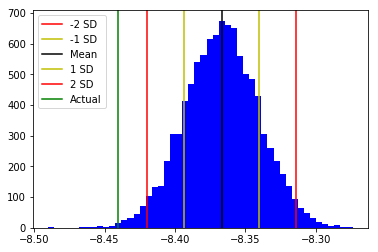

20.00 percent of data analyzed


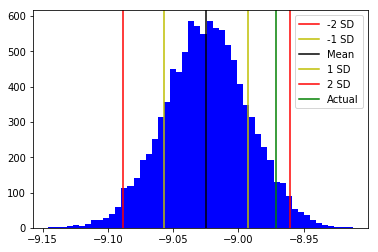

29.99 percent of data analyzed


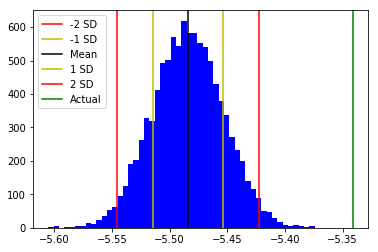

39.99 percent of data analyzed


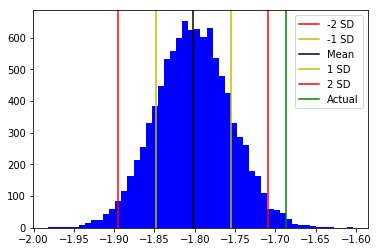

49.99 percent of data analyzed


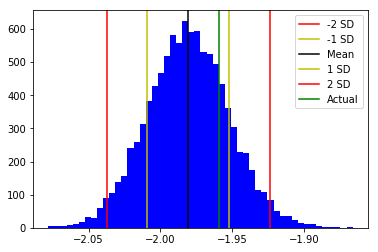

59.99 percent of data analyzed


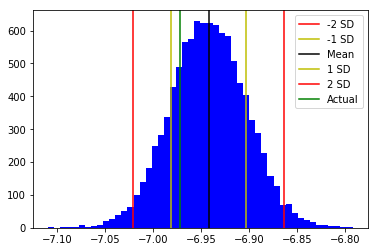

69.99 percent of data analyzed


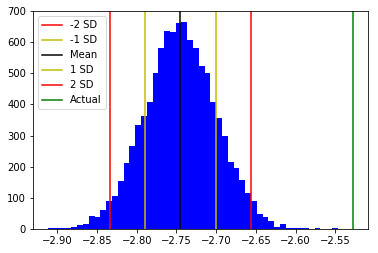

79.98 percent of data analyzed


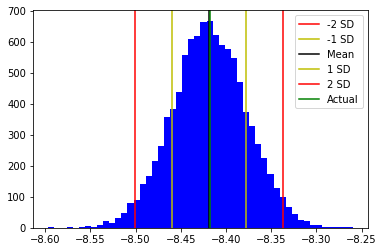

89.98 percent of data analyzed


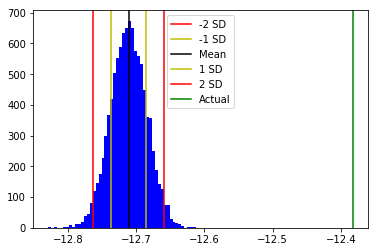

99.98 percent of data analyzed


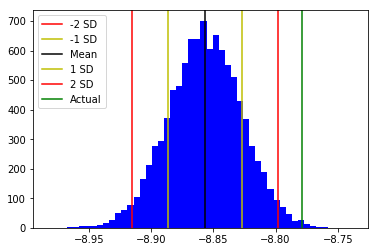

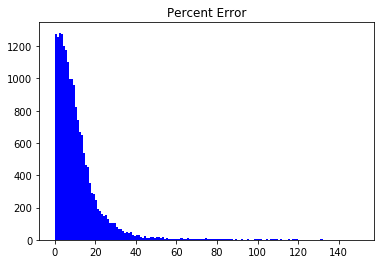

Percent Error Mean: 11.40010295767717
Percent Error Standard Deviation: 17.165939812903638

Number outside of 3 standard deviations: 6594
Number between 2 and 3 standard deviations: 3433
Number between 1 and 2 standard deviations: 4366
Number inside 1 standard deviation: 4921
Number below distribution minimum: 1360
Number above distribution maximum: 3236

Percent inside 1 standard deviation: 25.478927203065133
Percent inside 2 standard deviations: 48.08429118773947
Percent inside 3 standard deviations: 65.85896241068654
Percent outside 3 standard deviations: 34.14103758931345
Percent below distribution minimum: 7.041524282903593
Percent above distribution maximum: 16.75468572020296


In [1]:
import numpy as np
import tensorflow as tf
import pylab as plt

from scipy import stats
from BNN_functions import normalizeData, build_input_pipeline, runInference

%matplotlib inline

def main():
    """This script loads a previously created neural network created in
    BNN_train. It will then run the validation data through the network the
    number of times specified in iters. This data will be collected and fit
    to a normal distribution which can be compared to the actual data point.
    From this analysis the script will print the percent of the real data that
    falls within 1, 2, and 3 standard deviations of the predicted distributions.
    It will also print out the percent of data below the distribution min and
    above the max. Finally, in the file is given in out the script will write 
    the unnormalized mean, lower 95% confidence value, higher 95% confidence 
    value, the width of the 95% confidence interval, and the actual value.
    
    This script will also graph the output predictions for 10 points and create
    a histogram of the percent error from the network.
    """

    name="flipout_PRELU" #change to name of network
    out="flipout_PRELU" #change to desired name of output file
    iters=10000 #Number of predictions to make
    val_batch=None #Number of entries in a batch, None if it should be only 1 batch
    train_batch=128
    
    
    trainIn=np.loadtxt("fullTrainInput.txt",delimiter="\t",skiprows=1)
    trainOut=np.loadtxt("fullTrainOutput.txt",delimiter="\t",skiprows=1)
    valIn=np.loadtxt("fullValidateInput.txt",delimiter="\t",skiprows=0)
    valOut=np.loadtxt("fullValidateOutput.txt",delimiter="\t",skiprows=0)


    #Normalize the training and output data and collect the values used to do so
    normInfo, data = normalizeData(trainIn, trainOut, valIn, valOut)
        
    with tf.Session() as sess:
        
        #Load the previously created network
        print('\nLoading...')
        logits = tf.get_variable("logits",[])
        saver = tf.train.import_meta_graph(name+'.meta')
        saver.restore(sess, './'+name)
        graph = tf.get_default_graph()
        logits = graph.get_tensor_by_name("bayesian_neural_net/logits:0")
        rate = graph.get_tensor_by_name("rate:0")
        handle = graph.get_tensor_by_name("handle:0")
        print('Loaded')
        
        #values required to run network
        dropoutPercent=0.0
        
        #size of data
        train_size=len(trainIn[:,1])
        val_size=len(valIn[:,1])
        data_size=train_size+val_size
        
        #setup data pipelines
        (x_input, y_output, handle, training_iterator, validation_iterator) = build_input_pipeline(
           data, train_batch, randomize = False, val_batch=val_batch, handle=handle)
        
        #prediction operator
        pred = runInference(logits)
        
        #iterator handles
        train_handle = sess.run(training_iterator.string_handle())
        validate_handle = sess.run(validation_iterator.string_handle())
        
        #iterate over the input data several times
        allPredictions=np.zeros((iters,len(data[3])))
        steps=iters*len(data[3])
        decile=steps
        if(steps/10>=1):
            decile=int(steps/10)
        total=0
        while(total<steps):
            prediction= sess.run([pred], feed_dict={rate: dropoutPercent, handle: validate_handle})
            prediction=prediction[0]
            
            for j in range(len(prediction)):
                if(total<iters*len(data[3])):
                    allPredictions[int(total/len(data[3]))%iters,(total)%(len(data[3]))]=prediction[j]
                total+=1    
                if(total%decile==0):
                    print("{:.2f} percent of data generated".format(100*total/steps))
        
        real=data[3]*normInfo[0][1]+normInfo[0][0]
        wrong=[]
        sd3=[]
        sd2=[]
        sd1=[]
        belMin=[]
        abvMax=[]
        percentError=[]
        name=out+".txt"
        allPredictions=allPredictions*normInfo[0][1]+normInfo[0][0]
        with open(name, 'w') as file:
            decile=int(len(allPredictions[0,:])/10)
            for k in range(len(allPredictions[0,:])):
                #fit output distribution
                minimum=min(allPredictions[:,k])
                maximum=max(allPredictions[:,k])
                mean, sd = stats.norm.fit(allPredictions[:,k])
                
                #calculate the unnormalized values at each of the standard deviations
                low99=mean-sd*3
                low95=mean-sd*2
                low68=mean-sd
                high68=mean+sd
                high95=mean+sd*2
                high99=mean+sd*3
                actual=real[k]
                
                expLow=np.exp(low95)
                expHigh=np.exp(high95)
                expMean=np.exp(mean)
                expActual=np.exp(actual) 
                #write data to the output file
                file.write(str(expMean) + "\t" + str(expLow) + "\t" + 
                           str(expHigh) + "\t" + str(expHigh - expLow) + "\t" + 
                           str(expActual) + "\n")
                
                percentError.append(100*abs(expMean-expActual)/(expActual))
                
                #Compare values to distribution max and min
                if(actual<minimum):
                    belMin.append(k)
                elif(actual>maximum):
                    abvMax.append(k)    
                
                #Find out where the actual data point falls in the output distribtuion
                if(actual<low99 or actual>high99):
                    wrong.append(k)
                elif(actual<low95):
                    sd3.append(k)
                elif(actual<low68):
                    sd2.append(k)
                elif(actual<high68):
                    sd1.append(k)
                elif(actual<high95):
                    sd2.append(k)
                elif(actual<=high99):
                    sd3.append(k)
                if((k+1)%decile==0):
                    print("{:.2f} percent of data analyzed".format(100*(k+1)/len(allPredictions[0,:])))
                    plt.figure(k)
                    plt.hist(allPredictions[:,k],color="b", bins=50)

                    plt.axvline(x=low95,color="r")
                    plt.axvline(x=low68,color="y")
                    plt.axvline(x=mean,color="k")
                    plt.axvline(x=high68,color="y")
                    plt.axvline(x=high95,color="r")
                    plt.axvline(x=actual,color="g")
                    plt.legend(["-2 SD", "-1 SD", "Mean", "1 SD", "2 SD", "Actual"])
                    plt.show();
            
            mean, sd = stats.norm.fit(percentError)
            plt.figure(20)
            plt.hist(percentError,color="b", bins=150, range=(0,150))
            plt.title("Percent Error")
            plt.show()
            
            print("Percent Error Mean:", mean)
            print("Percent Error Standard Deviation:", sd)
            print()
            
            
            print("Number outside of 3 standard deviations:", len(wrong))
            print("Number between 2 and 3 standard deviations:", len(sd3))
            print("Number between 1 and 2 standard deviations:", len(sd2))
            print("Number inside 1 standard deviation:", len(sd1))
            print("Number below distribution minimum:", len(belMin))
            print("Number above distribution maximum:", len(abvMax))
            print()
            print("Percent inside 1 standard deviation:", 100*len(sd1)/len(allPredictions[0,:]))
            print("Percent inside 2 standard deviations:",100*(len(sd1)+len(sd2))/len(allPredictions[0,:]))
            print("Percent inside 3 standard deviations:",100*(len(sd1)+len(sd2)+len(sd3))/len(allPredictions[0,:]))
            print("Percent outside 3 standard deviations:", 100*len(wrong)/len(allPredictions[0,:]))
            print("Percent below distribution minimum:", 100*len(belMin)/len(allPredictions[0,:]))
            print("Percent above distribution maximum:", 100*len(abvMax)/len(allPredictions[0,:]))

if(__name__ == "__main__"):
    main()